# Categorical Embedding

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import chain
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.metrics import top_k_categorical_accuracy
from keras.models import Model
from keras.layers import Dense, Dropout, Input, Embedding,Reshape, Concatenate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score

## Data

In [2]:
data = pd.read_csv("./data/full_RASFF_DATA.csv", sep=";", header=0, index_col=0)
data = data.sample(frac=1)

data.head(1)

,CLASSIF,DATE_CASE,REF,NOT_COUNTRY,SUBJET,PROD_CAT,TYPE,RISK_DECISION,ACTION_TAKEN,DISTRIBUTION_STAT,PRODUCT,HAZARDS,HAZARDS_CAT,COUNT_ORIGEN,COUNT_DESTIN,COUNT_CONCERN,NUMBER
35081,alert,2010-06-01,2010.0690,Greece,inner coating oxidized of and inner coating pe...,food contact materials,fcm,undecided,withdrawal from the market,distribution on the market (possible),oven pan,"inner coating oxidized,inner coating peeling o...","migration,migration,migration",China,"Cyprus,Greece",,31433.0


In [3]:
class Stage:
	def __init__(self, input, output):
		self.input = input
		self.output = output

		self.x = data.iloc[:, input]
		self.y = data.iloc[:, output]

		self.x_train, self.y_train = None, None
		self.x_val, self.y_val = None, None
		self.x_test, self.y_test = None, None

		self.input_list_train, self.input_list_test, self.input_list_testval = None, None, None

		self.__transform()

	def __transform(self):
		train_val_mask = (data.DATE_CASE >= "2004-01-01") & (data.DATE_CASE <= "2018-12-31")
		test_mask = (data.DATE_CASE >= "2019-01-01") & (data.DATE_CASE <= "2019-12-31")

		strategy = OneHotEncoder(handle_unknown="ignore", sparse=False)
		strategy.fit(self.y.values)

		self.x_train = self.x.loc[train_val_mask]
		self.y_train = self.y.loc[train_val_mask]

		self.x_test = self.x.loc[test_mask]
		self.y_test = self.y.loc[test_mask]

		self.y_train = strategy.transform(self.y_train.values)
		self.y_test = strategy.transform(self.y_test.values)

		self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x_train, self.y_train, test_size=0.2, random_state=42)

	def get_metrics(self):
		result = model.predict(self.input_list_test, batch_size=64)
		result = np.argmax(result, axis=-1)

		print(f"- Accuracy: {round(accuracy_score(np.argmax(self.y_test, axis=-1), result)*100, 2)}%")
		print(f"- Specifity: {round(get_specifity(np.argmax(self.y_test, axis=-1), result)*100, 2)}%")
		print(f"- Sensitivity: {round(recall_score(np.argmax(self.y_test, axis=-1), result, average='macro', zero_division=0)*100, 2)}%")
		print(f"- Precision: {round(precision_score(np.argmax(self.y_test, axis=-1), result, average='macro', zero_division=0)*100, 2)}%")

		print(classification_report(np.argmax(self.y_test, axis=-1), result, zero_division=True))

		cm = confusion_matrix(np.argmax(self.y_test, axis=-1), result)
		cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(0, cm.shape[0])))

		_, ax = plt.subplots(figsize=(10, 10))
		cm.plot(ax=ax)

		plt.show()

## Preprocessing

In [4]:
data.DATE_CASE = data.DATE_CASE.astype(str)
data.HAZARDS_CAT = data.HAZARDS_CAT.astype(str)
data.COUNT_DESTIN = data.COUNT_DESTIN.astype(str)
data.COUNT_CONCERN = data.COUNT_CONCERN.astype(str)

data.dropna(subset=data.columns[[1, 3, 5, 8, 9, 12, 13]], inplace=True)

In [5]:
def preproc(X_train, X_test, X_val):
    input_list_train = []
    input_list_test = []
    input_list_testval = []
    
    for c in stage1.x.columns:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
        input_list_testval.append(X_val[c].map(val_map).fillna(0).values)

    return input_list_train, input_list_test,input_list_testval

In [6]:
def get_specifity(y_actual, y_pred):
    TN = []
    FP = []

    for index ,_id in enumerate(np.union1d(y_actual, y_pred)):
        FP.append(0)
        TN.append(0)

        for i in range(len(y_pred)):
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1

    TN = sum(TN)
    FP = sum(FP)

    return TN/(TN + FP)

## Transformation

In [7]:
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

lens = data['HAZARDS_CAT'].str.split(',').map(len)
split1 = pd.DataFrame({'DATE_CASE': np.repeat(data['DATE_CASE'], lens),
                    'NOT_COUNTRY': np.repeat(data['NOT_COUNTRY'], lens),
                    'PROD_CAT': np.repeat(data['PROD_CAT'], lens),
                    'TYPE': np.repeat(data['TYPE'], lens),
                    'RISK_DECISION': np.repeat(data['RISK_DECISION'], lens),
                    'ACTION_TAKEN': np.repeat(data['ACTION_TAKEN'], lens),
                    'DISTRIBUTION_STAT': np.repeat(data['DISTRIBUTION_STAT'], lens),
                    'HAZARDS_CAT': chainer(data['HAZARDS_CAT']),
                    'COUNT_ORIGEN': np.repeat(data['COUNT_ORIGEN'], lens),
                    'COUNT_DESTIN': np.repeat(data['COUNT_DESTIN'], lens),
                    'COUNT_CONCERN': np.repeat(data['COUNT_CONCERN'], lens)})

lens = split1['COUNT_ORIGEN'].str.split(',').map(len)
split2 = pd.DataFrame({'DATE_CASE': np.repeat(split1['DATE_CASE'], lens),
                    'NOT_COUNTRY': np.repeat(split1['NOT_COUNTRY'], lens),
                    'PROD_CAT': np.repeat(split1['PROD_CAT'], lens),
                    'TYPE': np.repeat(split1['TYPE'], lens),
                    'RISK_DECISION': np.repeat(split1['RISK_DECISION'], lens),
                    'ACTION_TAKEN': np.repeat(split1['ACTION_TAKEN'], lens),
                    'DISTRIBUTION_STAT': np.repeat(split1['DISTRIBUTION_STAT'], lens),
                    'HAZARDS_CAT': np.repeat(split1['HAZARDS_CAT'], lens),
                    'COUNT_ORIGEN': chainer(split1['COUNT_ORIGEN']),
                    'COUNT_DESTIN': np.repeat(split1['COUNT_DESTIN'], lens),
                    'COUNT_CONCERN': np.repeat(split1['COUNT_CONCERN'], lens)})

lens = split2['COUNT_DESTIN'].str.split(',').map(len)
split3 = pd.DataFrame({'DATE_CASE': np.repeat(split2['DATE_CASE'], lens),
                    'NOT_COUNTRY': np.repeat(split2['NOT_COUNTRY'], lens),
                    'PROD_CAT': np.repeat(split2['PROD_CAT'], lens),
                    'TYPE': np.repeat(split2['TYPE'], lens),
                    'RISK_DECISION': np.repeat(split2['RISK_DECISION'], lens),
                    'ACTION_TAKEN': np.repeat(split2['ACTION_TAKEN'], lens),
                    'DISTRIBUTION_STAT': np.repeat(split2['DISTRIBUTION_STAT'], lens),
                    'HAZARDS_CAT': np.repeat(split2['HAZARDS_CAT'], lens),
                    'COUNT_ORIGEN': np.repeat(split2['COUNT_ORIGEN'], lens),
                    'COUNT_DESTIN': chainer(split2['COUNT_DESTIN']),
                    'COUNT_CONCERN': np.repeat(split2['COUNT_CONCERN'], lens)})

lens = split3['COUNT_CONCERN'].str.split(',').map(len)
split4 = pd.DataFrame({'DATE_CASE': np.repeat(split3['DATE_CASE'], lens),
                    'NOT_COUNTRY': np.repeat(split3['NOT_COUNTRY'], lens),
                    'PROD_CAT': np.repeat(split3['PROD_CAT'], lens),
                    'TYPE': np.repeat(split3['TYPE'], lens),
                    'RISK_DECISION': np.repeat(split3['RISK_DECISION'], lens),
                    'ACTION_TAKEN': np.repeat(split3['ACTION_TAKEN'], lens),
                    'DISTRIBUTION_STAT': np.repeat(split3['DISTRIBUTION_STAT'], lens),
                    'HAZARDS_CAT': np.repeat(split3['HAZARDS_CAT'], lens),
                    'COUNT_ORIGEN': np.repeat(split3['COUNT_ORIGEN'], lens),
                    'COUNT_DESTIN': np.repeat(split3['COUNT_DESTIN'], lens),
                    'COUNT_CONCERN': chainer(split3['COUNT_CONCERN'])})

split4 = split4.reset_index(drop = True)
split4 = split4.dropna(subset = ['DATE_CASE'])

data = split4.copy()

In [8]:
data.head(1)

,DATE_CASE,NOT_COUNTRY,PROD_CAT,TYPE,RISK_DECISION,ACTION_TAKEN,DISTRIBUTION_STAT,HAZARDS_CAT,COUNT_ORIGEN,COUNT_DESTIN,COUNT_CONCERN
0,2010-06-01,Greece,food contact materials,fcm,undecided,withdrawal from the market,distribution on the market (possible),migration,China,Cyprus,


## Data Mining

In [9]:
stage1 = Stage(
	input=[0, 1, 6, 8],
	output=[2]
)

In [10]:
def top_1_categorical_accuracy(y_true, y_pred):
	return top_k_categorical_accuracy(y_true, y_pred, k=1)

def top_2_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [11]:
input_models = []
output_embeddings = []

for categorical_var in stage1.x.columns:
    cat_emb_name = categorical_var.replace(" ", "") + "_Embedding"
    input_name = "Input_" + categorical_var.replace(" ", "")
    no_of_unique_cat = stage1.x_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50))
   
    input_model = Input(shape=(1, ), name=input_name)
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size, ))(output_model)    
    
    input_models.append(input_model)
    output_embeddings.append(output_model)
  
output = Concatenate()(output_embeddings)
output = Dense(2048,activation="relu")(output)
output = Dropout(0.3)(output)
output = Dense(1024,activation="relu")(output)
output = Dropout(0.2)(output)
output = Dense(512,activation="relu")(output)
output = Dropout(0.2)(output)
output = Dense(43, activation="softmax")(output)

model = Model(inputs=input_models, outputs=output)

In [12]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", top_1_categorical_accuracy,top_2_categorical_accuracy,top_3_categorical_accuracy])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_DATE_CASE (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_NOT_COUNTRY (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_DISTRIBUTION_STAT (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_COUNT_ORIGEN (InputLayer) [(None, 1)]          0                                            
______________________________________________________________________________________________

In [13]:
stage1.input_list_train, stage1.input_list_test, stage1.input_list_testval = preproc(stage1.x_train, stage1.x_test, stage1.x_val)

hist = model.fit(stage1.input_list_train, stage1.y_train, validation_data=(stage1.input_list_testval, stage1.y_val), epochs=5, batch_size=64, verbose=1)

Epoch 1/5
1647/1647 [==============================] - 66s 39ms/step - loss: 1.6085 - accuracy: 0.5695 - top_1_categorical_accuracy: 0.5695 - top_2_categorical_accuracy: 0.6788 - top_3_categorical_accuracy: 0.7373 - val_loss: 1.1788 - val_accuracy: 0.6828 - val_top_1_categorical_accuracy: 0.6828 - val_top_2_categorical_accuracy: 0.7785 - val_top_3_categorical_accuracy: 0.8266
Epoch 2/5
1647/1647 [==============================] - 66s 40ms/step - loss: 0.9757 - accuracy: 0.7365 - top_1_categorical_accuracy: 0.7365 - top_2_categorical_accuracy: 0.8254 - top_3_categorical_accuracy: 0.8678 - val_loss: 0.9372 - val_accuracy: 0.7460 - val_top_1_categorical_accuracy: 0.7460 - val_top_2_categorical_accuracy: 0.8322 - val_top_3_categorical_accuracy: 0.8707
Epoch 3/5
1647/1647 [==============================] - 65s 39ms/step - loss: 0.7020 - accuracy: 0.8039 - top_1_categorical_accuracy: 0.8039 - top_2_categorical_accuracy: 0.8813 - top_3_categorical_accuracy: 0.9138 - val_loss: 0.8346 - val_acc

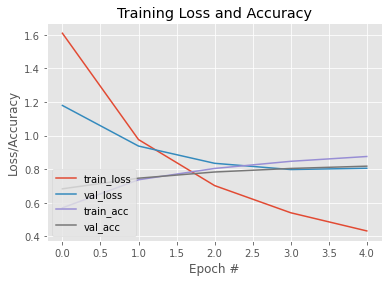

In [15]:
plt.style.use("ggplot")

plt.figure()

plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot(hist.history["accuracy"], label="train_acc")
plt.plot(hist.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

- Accuracy: 24.13%
- Specifity: 91.97%
- Sensitivity: 10.71%
- Precision: 15.16%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           2       0.00      1.00      0.00         0
           3       0.09      0.15      0.11       189
           4       0.00      0.00      0.00        49
           5       0.17      0.08      0.11       715
           6       0.06      0.03      0.04       336
           7       1.00      0.00      0.00        31
           8       0.05      0.05      0.05       396
           9       0.21      0.21      0.21       103
          10       0.78      0.38      0.51      1652
          11       1.00      0.00      0.00        71
          14       0.35      0.35      0.35       551
          15       1.00      0.00      0.00        51
          16       0.00      1.00      0.00         0
          17       0.65      0.06      0.11       474
          18       1.00      0.00      0.00         4


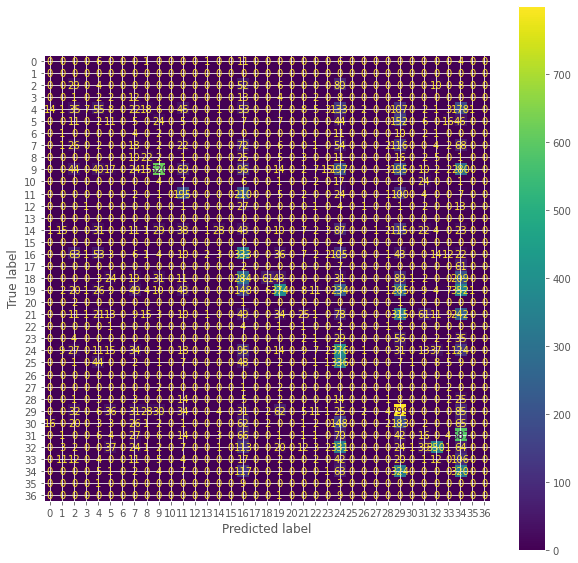

In [16]:
stage1.get_metrics()

In [ ]:
historials = []
evaluations = []

for i in range (1, 6):
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", top_1_categorical_accuracy, top_2_categorical_accuracy, top_3_categorical_accuracy])
    
    hist = model.fit(stage1.input_list_train, stage1.y_train, validation_data=(stage1.input_list_testval, stage1.y_val), epochs=25, batch_size=64, verbose=0)
    historials.append(hist)
    
    evaluation = model.evaluate(x=stage1.input_list_test, y=stage1.y_test)
    evaluations.append(evaluation)
    
    model.save("model" + str(i) + ".h5")

    stage1.get_metrics()

    print("\n\n-----------------------\n")